In [1]:
import sys

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from bindsnet.environment import GymEnvironment
from bindsnet.learning.reward import AbstractReward, MovingAvgRPE
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_weights
from agents import AcrobotObserverAgent, ExpertAcrobotAgent
from pipelines import AcrobotPipeline

In [3]:
def _compute_spikes(
    datum: torch.Tensor,
    time: int,
    low: float,
    high: float,
    device: str
) -> torch.Tensor:
    times = torch.linspace(low, high, time, device=device)
    spike_times = torch.argmin(torch.abs(datum - times))
    spikes = (np.array(spike_times.to('cpu')).astype(int) ==
              range(0, time)).astype(int)
    reverse_spikes = np.flip(spikes).copy()
    return torch.stack([
        torch.from_numpy(spikes).to(device),
        torch.from_numpy(reverse_spikes).to(device)
    ]).byte()

In [4]:
def acrobot_observation_encoder(
        datum: torch.Tensor,
        time: int,
        **kwargs,
) -> dict:
    """

    Parameters
    ----------
    datum : torch.Tensor
        Observation tensor.
    time : int
        Length of spike train per observation.

    Keyword Arguments
    -----------------

    Returns
    -------
    dict
        The tensor of encoded data per input population.

    """
    device = "cpu" if datum.get_device() < 0 else 'cuda'
    datum = datum.squeeze()
    if (len(datum)==6):
        cos1, sin1, cos2, sin2, vel1, vel2 = datum
    else:
        theta1, theta2, vel1, vel2 = datum
        cos1 = np.cos(theta1)
        sin1 = np.sin(theta1)
        cos2 = np.cos(theta2)
        sin2 = np.sin(theta2)
    
    min_cos1, max_cos1 = -1.0, 1.0
    min_sin1, max_sin1 = -1.0, 1.0
    min_cos2, max_cos2 = -1.0, 1.0
    min_sin2, max_sin2 = -1.0, 1.0
    min_vel1, max_vel1 = -12.57, 12.57
    min_vel2, max_vel2 = -28.27, 28.27

    cos1_spikes = _compute_spikes(cos1, time, min_cos1, max_cos1, device)
    sin1_spikes = _compute_spikes(sin1, time, min_sin1, max_sin1, device)
    cos2_spikes = _compute_spikes(cos2, time, min_cos2, max_cos2, device)
    sin2_spikes = _compute_spikes(sin2, time, min_sin2, max_sin2, device)
    vel1_spikes = _compute_spikes(vel1, time, min_vel1, max_vel1, device)
    vel2_spikes = _compute_spikes(vel2, time, min_vel2, max_vel2, device)

    spikes = torch.stack([cos1_spikes, sin1_spikes, cos2_spikes, sin2_spikes, vel1_spikes, vel2_spikes]).T

    return {"S2": spikes.unsqueeze(1).byte().to(device)}
#     return {"S2": torch.reshape(spikes.unsqueeze(1).byte().to(device), (time, 1, 6, 2))}

In [5]:
def _noise_policy(episode, num_episodes, **kwargs):
    return 0

In [6]:
# Define the environment
environment = GymEnvironment('Acrobot-v1', render_mode='human')

In [7]:
# Define observer agent
observer = AcrobotObserverAgent(environment, dt=1.0, method='first_spike')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class Policy(nn.Module):
    def __init__(self, s_size=6, h_size=32, a_size=3):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # print("x: ", x)
        # print("x shape: ", x.shape)
        return F.softmax(x, dim=0)
    
    def act(self, state):
        if isinstance(state, tuple):
            state = torch.from_numpy(state[0]).float().unsqueeze(0).to(device)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # print("act state: ", state)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item() - 1, m.log_prob(action)
    
    def save(self, filename):
        torch.save(self.state_dict(), '%s.pth' % (filename))

In [10]:
def expert_forward(state, weight='./acrobot_model.pth', **kwargs):
    model = Policy()
    if isinstance(weight, str):
        weight = torch.load(weight)
    model.load_state_dict(weight)
    
    if (state.shape[0] == 4):
        cos1 = np.cos(state[0])
        sin1 = np.sin(state[0])
        cos2 = np.cos(state[1])
        sin2 = np.sin(state[1])
        vel1 = state[2]
        vel2 = state[3]
    else:
        cos1, sin1, cos2, sin2, vel1, vel2 = state
    
    obs = torch.tensor([cos1, sin1, cos2, sin2, vel1, vel2])

    q = model(obs)
    
    return torch.argmax(q).item() - 1

In [11]:
# Define expert agent acting on pretrained weights (weight is multiplied by
# observation vector)
expert = ExpertAcrobotAgent(environment, method='user-defined',
                     noise_policy=_noise_policy)

In [12]:
# Define the pipeline by which the agents interact
pipeline = AcrobotPipeline(
    observer_agent=observer,
    expert_agent=expert,
    encoding=acrobot_observation_encoder,
    time=25,
    num_episodes=200,
    representation_time=12,
    log_writer = True,
    render_interval=5,
    keep_state = True,
)

In [13]:
pipeline.observe_learn(function=expert_forward, weight='./acrobot_model.pth',
                              test_interval=15, num_tests=7)
print("Observation Finished")

Episode: 0 - accumulated reward: -81.00
Episode: 1 - accumulated reward: -79.00
Episode: 2 - accumulated reward: -78.00
Episode: 3 - accumulated reward: -85.00
Episode: 4 - accumulated reward: -86.00
Episode: 5 - accumulated reward: -139.00
Episode: 6 - accumulated reward: -89.00
Episode: 7 - accumulated reward: -73.00
Episode: 8 - accumulated reward: -92.00
Episode: 9 - accumulated reward: -76.00
Episode: 10 - accumulated reward: -77.00
Episode: 11 - accumulated reward: -82.00
Episode: 12 - accumulated reward: -87.00
Episode: 13 - accumulated reward: -81.00
Episode: 14 - accumulated reward: -78.00
Test - accumulated reward: -267.0
Test - accumulated reward: -241.0
Test - accumulated reward: -188.0
Test - accumulated reward: -468.0
Test - accumulated reward: -290.0
Test - accumulated reward: -281.0
Test - accumulated reward: -364.0
Episode: 15 - accumulated reward: -84.00
Episode: 16 - accumulated reward: -81.00
Episode: 17 - accumulated reward: -94.00
Episode: 18 - accumulated reward:

Episode: 147 - accumulated reward: -77.00
Episode: 148 - accumulated reward: -99.00
Episode: 149 - accumulated reward: -86.00
Test - accumulated reward: -298.0
Test - accumulated reward: -209.0
Test - accumulated reward: -357.0
Test - accumulated reward: -212.0
Test - accumulated reward: -273.0
Test - accumulated reward: -240.0
Test - accumulated reward: -283.0
Episode: 150 - accumulated reward: -97.00
Episode: 151 - accumulated reward: -93.00
Episode: 152 - accumulated reward: -71.00
Episode: 153 - accumulated reward: -126.00
Episode: 154 - accumulated reward: -322.00
Episode: 155 - accumulated reward: -83.00
Episode: 156 - accumulated reward: -85.00
Episode: 157 - accumulated reward: -77.00
Episode: 158 - accumulated reward: -81.00
Episode: 159 - accumulated reward: -81.00
Episode: 160 - accumulated reward: -78.00
Episode: 161 - accumulated reward: -87.00
Episode: 162 - accumulated reward: -77.00
Episode: 163 - accumulated reward: -74.00
Episode: 164 - accumulated reward: -77.00
Test

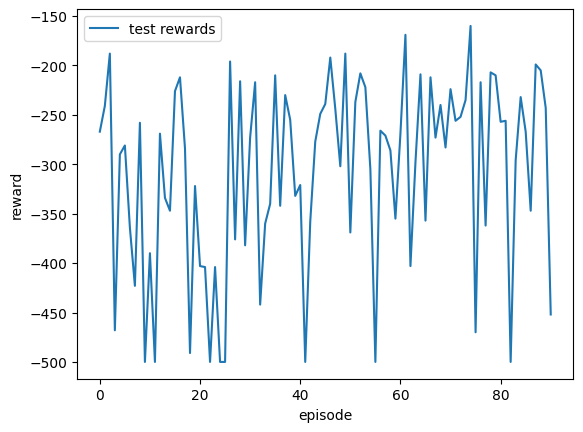

In [14]:
plt.plot(pipeline.test_rewards, label='test rewards')
plt.xlabel("episode")
plt.ylabel("reward")
plt.legend()
plt.savefig(f"test_rewards_{5_11_10_5_50}.png")

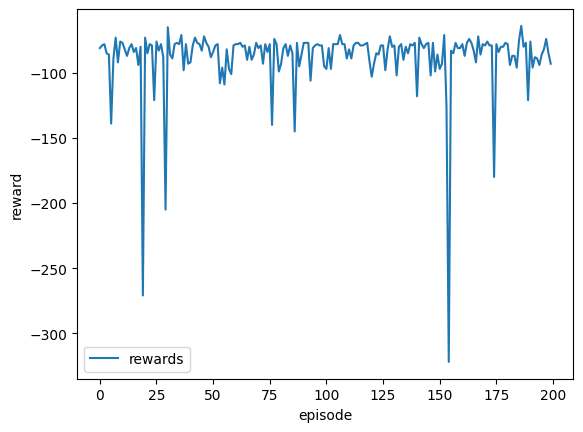

In [15]:
plt.plot(pipeline.reward_list, label='rewards')
plt.xlabel("episode")
plt.ylabel("reward")
plt.legend()
plt.savefig(f"rewards_{5_11}.png")

In [16]:
np.mean(pipeline.test_rewards)

-307.53846153846155

In [17]:
w1 = pipeline.network.connections[("S2", "PM")].w
# plot_weights(w1)
print(w1)

Parameter containing:
tensor([[ 0.6258,  0.3643,  0.3090],
        [ 0.2639,  0.2006,  0.2157],
        [ 0.3718,  0.3051,  0.2995],
        [ 0.2890,  0.2930,  0.2826],
        [ 0.3692,  0.1987,  0.0983],
        [-1.0000,  0.1159,  0.0681],
        [-0.4597,  0.1808,  0.2764],
        [ 0.1813,  0.2315,  0.2361],
        [-0.1710,  0.2626,  0.2631],
        [ 0.2382,  0.2356,  0.2314],
        [-0.8509, -0.0143,  0.0858],
        [ 0.8974,  0.0355,  0.0959]])


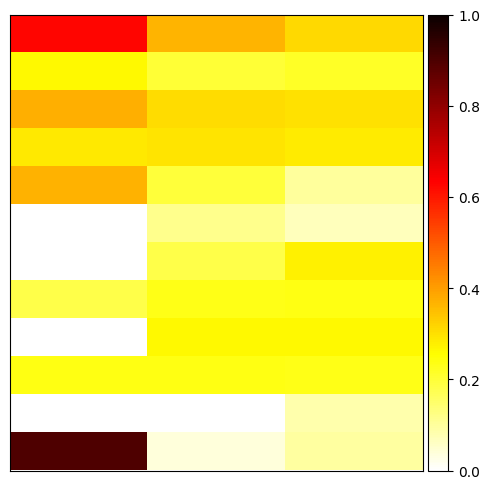

In [18]:
plot_weights(w1)

In [19]:
w2 = pipeline.network.connections[("PM", "PM")].w
# plot_weights(w1)
print(w2)

Parameter containing:
tensor([-0.5000, -0.5000, -0.5000])


In [20]:
pipeline.network.monitors['PMS'].get('s').shape

torch.Size([25, 1, 3, 1])

In [21]:
pipeline.network.monitors['PMS'].get('s').nonzero()

tensor([[12,  0,  0,  0]])

In [22]:
pipeline.network.monitors['PMV'].get('v')

tensor([[[[-64.6873],
          [-64.6972],
          [-64.6836]]],


        [[[-64.8103],
          [-64.8163],
          [-64.8081]]],


        [[[-64.7036],
          [-64.6571],
          [-64.6475]]],


        [[[-64.8202],
          [-64.7920],
          [-64.7862]]],


        [[[-65.0619],
          [-64.6112],
          [-64.6072]]],


        [[[-64.7994],
          [-64.5286],
          [-64.5303]]],


        [[[-64.8783],
          [-64.7141],
          [-64.7151]]],


        [[[-64.9262],
          [-64.8266],
          [-64.8272]]],


        [[[-64.3294],
          [-64.5305],
          [-64.5862]]],


        [[[-65.5933],
          [-64.5994],
          [-64.6809]]],


        [[[-65.3598],
          [-64.7570],
          [-64.8065]]],


        [[[-66.0692],
          [-64.8669],
          [-64.7968]]],


        [[[-65.6485],
          [-64.9193],
          [-64.8768]]],


        [[[-65.8933],
          [-65.4510],
          [-65.4253]]],


        [[[-65.5418]

In [23]:
pipeline.network.monitors['PMV'].get('v').shape

torch.Size([25, 1, 3, 1])